This notebook walks through the preprocessing/QA workflow described in the course slides.

In [4]:
import os
try:
    assert 1==0
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'
print 'Using data from',datadir

%matplotlib inline

from nipype.interfaces import fsl
import nibabel
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from compute_fd_dvars import compute_fd,compute_dvars


Using data from /Users/poldrack/data_unsynced/myconnectome/sub00001


Load the data

In [5]:
subject='ses014'  

bolddir=os.path.join(datadir,subject,
        'functional')
boldfile=os.path.join(bolddir,'sub00001_ses014_task002_run001_bold.nii.gz')
boldimg=nibabel.load(boldfile)
bolddata=boldimg.get_data()

Perform motion correction using FSL's mcflirt - this will take about a minute.

In [6]:
mcf_boldfile=boldfile.replace('.nii.gz','_mcf.nii.gz')
mcflt = fsl.MCFLIRT(in_file=boldfile,
                    out_file=mcf_boldfile,
                   save_plots=True)
result = mcflt.run() 

Compute the mean across timepoints and save to a file

In [7]:
boldimg=nibabel.load(mcf_boldfile)
bolddata=boldimg.get_data()

boldmean=numpy.mean(bolddata,3)
meanimg=nibabel.Nifti1Image(boldmean,affine=boldimg.get_affine())
meanboldfile=mcf_boldfile.replace('.nii.gz','_mean.nii.gz')
meanimg.to_filename(meanboldfile)

Use FSL's BET to obtain the brain mask

In [8]:
meanbrainfile=meanboldfile.replace('.nii.gz','_brain.nii.gz')
bet = fsl.BET()
bet.inputs.in_file = meanboldfile
bet.inputs.out_file = meanbrainfile
bet.inputs.mask=True
bet = bet.run() 

Display the mean image, and show the outline of the brain mask.

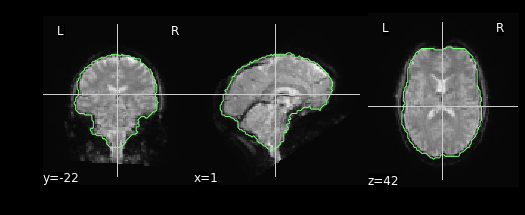

In [9]:
meanbrainmask=nibabel.load(meanbrainfile.replace('_brain','_brain_mask'))
maskdata=meanbrainmask.get_data()

mask_display=nilearn.plotting.plot_epi(meanimg,cmap='gray')
mask_display.add_contours(meanbrainmask, levels=[.5]) 

Compute and plot the global signal within the mask across timepoints

In [10]:
maskvox=numpy.where(maskdata)
globalmean=numpy.zeros(bolddata.shape[3])
globalcv=numpy.zeros(bolddata.shape[3])
for t in range(bolddata.shape[3]):
    tmp=bolddata[:,:,:,t]
    globalmean[t]=numpy.mean(tmp[maskvox])
    globalcv[t]=numpy.std(tmp[maskvox])/numpy.mean(tmp[maskvox])
    

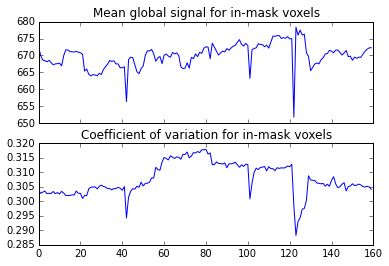

Load motion data and compute FD/DVARS

In [11]:
motionfile=mcf_boldfile+'.par'
motiondata=numpy.loadtxt(motionfile)
fd=compute_fd(motiondata)
dvars=compute_dvars(globalmean)

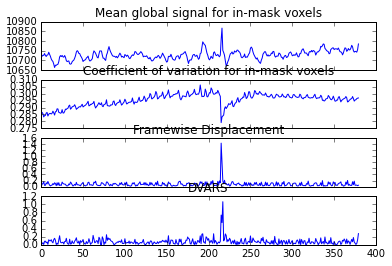

In [12]:
f, (ax1, ax2,ax3,ax4)=plt.subplots(4, sharex=True)
ax1.plot(globalmean)
ax1.set_title('Mean global signal for in-mask voxels')

ax2.plot(globalcv)
ax2.set_title('Coefficient of variation for in-mask voxels')

ax3.plot(fd)
ax3.set_title('Framewise Displacement')

ax4.plot(dvars)
ax4.set_title('DVARS')


Run independent components analysis on the data using MELODIC - this will take a few minutes.

In [13]:
icadir=mcf_boldfile.replace('.nii.gz','.ica')
melodic=fsl.MELODIC(out_all=True,report=True)
melodic.inputs.in_files=mcf_boldfile
melodic.inputs.out_dir=icadir
try:
    melodic.run()
except:
    pass # melodic seems to crash after it's done

Load the ICA components and examine their correlation with the motion signals. For components with a correlation > 0.4, show the component voxels.

In [14]:
ica_comps=numpy.loadtxt(os.path.join(icadir,'melodic_mix'))

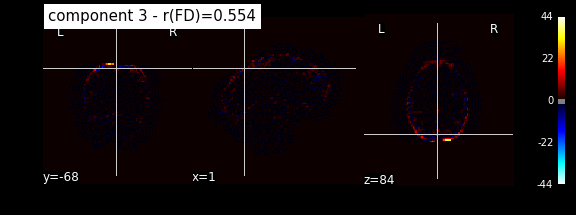

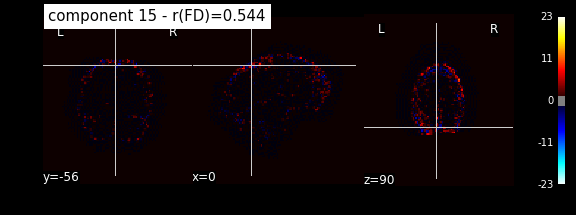

In [16]:
ica_motion_corr=numpy.zeros(ica_comps.shape[1])
for c in range(ica_comps.shape[1]):
    ica_motion_corr[c]=numpy.corrcoef(ica_comps[:,c],fd)[0,1]
    if abs(ica_motion_corr[c])>0.4:
        comp_img=nibabel.load(os.path.join(icadir,'stats/thresh_zstat%d.nii.gz'%int(c+1)))
        nilearn.plotting.plot_stat_map(comp_img,meanimg,threshold=1.5,
               title='component %d - r(FD)=%0.3f'%(c+1,ica_motion_corr[c]))

Use fieldmap to perform distortion correction.  First we need to prepare the fieldmap; this will take a few minutes.


In [21]:
# first make necessary magnitude difference file
magfile=os.path.join(datadir,subject,
                'fieldmap/sub00001_ses014_001_magnitude.nii.gz')
magimg=nibabel.load(magfile)
magdata=magimg.get_data()
magdiff=magdata[:,:,:,0]-magdata[:,:,:,1]
magdiffimg=nibabel.Nifti1Image(magdiff,magimg.get_affine())
magdiffimg.to_filename(magfile.replace('magnitude','magdiff'))

# prepare the fieldmap
prepare = fsl.PrepareFieldmap()
prepare.inputs.in_phase = os.path.join(datadir,subject,
                'fieldmap/sub00001_ses014_001_phasediff.nii.gz')
prepare.inputs.in_magnitude = magfile.replace('magnitude','magdiff')
prepare.inputs.output_type = "NIFTI_GZ"
prepare.inputs.out_fieldmap=os.path.join(datadir,subject,
                'fieldmap/sub00001_ses014_001_fmap.nii.gz')
prepare.run()


INFO:interface:stdout 2015-07-11T17:04:42.194178:Loading volumes
INFO:interface:stdout 2015-07-11T17:04:42.275613:Phase loaded
INFO:interface:stdout 2015-07-11T17:04:42.326982:Magnitude loaded
INFO:interface:stdout 2015-07-11T17:04:42.380195:Mask loaded
INFO:interface:stdout 2015-07-11T17:04:42.386775:Rewrapping phase range to [-pi,pi]
INFO:interface:stdout 2015-07-11T17:04:42.770543:Number of phase splits = 8
INFO:interface:stdout 2015-07-11T17:04:42.933593:Calculating starting matrices (74222 by 74222)
INFO:interface:stdout 2015-07-11T17:04:43.041139:Finished connection_matrices
INFO:interface:stdout 2015-07-11T17:04:43.046075:152944 constraints left
INFO:interface:stdout 2015-07-11T17:04:52.277841:132688 constraints left
INFO:interface:stdout 2015-07-11T17:05:01.298323:126674 constraints left
INFO:interface:stdout 2015-07-11T17:05:10.320694:122529 constraints left
INFO:interface:stdout 2015-07-11T17:05:18.041500:118857 constraints left
INFO:interface:stdout 2015-07-11T17:05:25.95947

In [23]:
fugue = fsl.preprocess.FUGUE()
fugue.inputs.in_file = meanbrainfile
fugue.inputs.mask_file = meanbrainfile.replace('_brain','_brain_mask')
fugue.inputs.fmap_in_file = os.path.join(datadir,subject,
                'fieldmap/sub00001_ses014_001_fmap.nii.gz')

fugue.inputs.dwell_time = 2.6/10000.0
fugue.inputs.unwarp_direction = 'y'
fugue.inputs.save_shift = True
fugue.inputs.unwarped_file=meanbrainfile.replace('.nii.gz',
                            '_unwarped.nii.gz')

fugue.inputs.output_type = "NIFTI_GZ"

fugue.run()

Display difference between original and undistorted image

17756.2


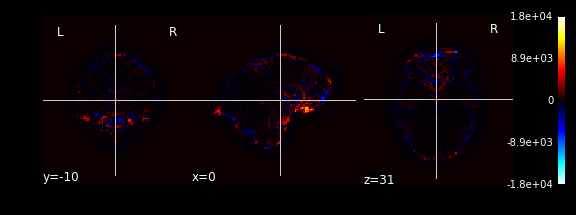

In [35]:
unwarped_img=nibabel.load(meanbrainfile.replace('.nii.gz',
                            '_unwarped.nii.gz'))
meanbrainimg=nibabel.load(meanbrainfile)

unwarp_diff=unwarped_img.get_data() - meanbrainimg.get_data()
print numpy.max(unwarp_diff)
unwarp_diff_img=nibabel.Nifti1Image(unwarp_diff,unwarped_img.get_affine())
fmap_display=nilearn.plotting.plot_stat_map(unwarp_diff_img,meanimg)
